<a href="https://colab.research.google.com/github/christymarc/BeachImageClassification/blob/main/BeachClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import fastai
from pathlib import Path
from PIL import Image
from urllib import request
from io import BytesIO
import pandas as pd
import urllib.request
import requests
import tensorflow as tf
from keras.preprocessing.image import *
from keras.applications import mobilenet_v2
import os
import shutil
import cv2
import imghdr

In [2]:
CLASSES = ['cleanBeach', 'dirtyBeach']
HEADERS = {
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36"
}
VALID_PCT = 0.2
IMG_SIZE = 224
BATCH_SIZE = 32
DATA_PATH = Path('/content/data/')

In [ ]:
def loadImage(URL):
    with urllib.request.urlopen(URL) as url:
        img = image.load_img(BytesIO(url.read()), target_size=(IMG_SIZE, IMG_SIZE))
    return image.img_to_array(img)

Loading in Clean Beach Data

In [ ]:
file = 'cleanBeaches.txt'
opened_file = open(DATA_PATH/file, 'r')
lines = opened_file.readlines()

In [ ]:
len(lines)

775

In [ ]:
count = 0
path = "data/cleanBeach/"
for line in lines:
    count += 1
    line = line.strip()
    try:
        r = requests.get(line, headers=HEADERS)
        with open(path + f'{count:05}' + '.jpg', 'wb') as outfile:
            outfile.write(r.content)
    except requests.ConnectionError: 
        pass

Loading in Dirty Beach Data

In [ ]:
file = 'dirtyBeaches.txt'
opened_file = open(DATA_PATH/file, 'r')
lines = opened_file.readlines()

In [ ]:
len(lines)

588

In [ ]:
count = 0
path = "data/dirtyBeach/"
for line in lines:
    count += 1
    line = line.strip()
    try:
        r = requests.get(line, headers=HEADERS)
        with open(path + f'{count:05}' + '.jpg', 'wb') as outfile:
            outfile.write(r.content)
    except requests.ConnectionError: 
        pass

Delete extra class (".ipynb_checkpoints")

In [5]:
os.listdir("/content/data")

['.DS_Store',
 'dirtyBeaches.txt',
 'cleanBeach',
 '.ipynb_checkpoints',
 'cleanBeaches.txt',
 'dirtyBeach']

In [ ]:
shutil.rmtree("/content/data/dirtyBeach/.ipynb_checkpoints")
shutil.rmtree("/content/data/cleanBeach/.ipynb_checkpoints")

FileNotFoundError: ignored

In [6]:
shutil.rmtree("data/.ipynb_checkpoints") #be careful with shutil.rmtree() because it deletes every tree in that path. In other words, do not make mistakes.

In [11]:
os.listdir("/content/data")

['cleanBeach',
 'cleanBeaches.txt',
 '.DS_Store',
 'dirtyBeaches.txt',
 'dirtyBeach']

ensuring correct image type

In [ ]:
def check_images(s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'/content/data'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print(bad_file_list[i])
        # Load image
        image = cv2.imread(bad_file_list[i])
        if (image is not None):
          # Save as proper .jpg image
          cv2.imwrite(bad_file_list[i], image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
        elif (os.path.exists(bad_file_list[i])):
          os.remove(bad_file_list[i])
          print("deleted file: " + bad_file_list[i])
else:
    print(' no improper image files were found')

zip files to download

In [ ]:
!zip -r /content/beachData.zip /content/data

In [ ]:
from google.colab import files
files.download("/content/beachData.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cleaning data separately. Now unzip data

In [3]:
!unzip /content/drive/MyDrive/beach_classifier_data/data.zip

Archive:  /content/drive/MyDrive/beach_classifier_data/data.zip
replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Split data into training and verification data

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_PATH,
  validation_split=VALID_PCT,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 1153 files belonging to 2 classes.
Using 923 files for training.


In [4]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_PATH,
  validation_split=VALID_PCT,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 1153 files belonging to 2 classes.
Using 230 files for validation.


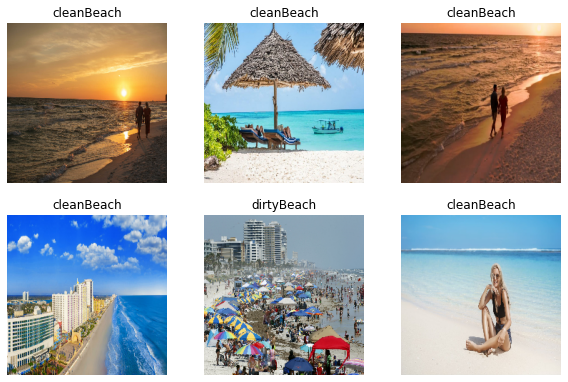

In [5]:
import matplotlib.pyplot as plt
import matplotlib.figure
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

Create and train the network

Since our dataset is on the small side, we will do some data augmentation to reduce overfitting. By augmenting the data, we are introducing more image 
variety into the dataset as well. 

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Because we will be using a pretrained MobileNetV2 (for its space efficiency, speed, and accuracy), we need to rescale our pixel values to be between [-1,1] -- right now they are [0, 255].

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),     # 3 specifies number of channels (rgb)
                                               include_top=False,
                                               weights='imagenet')

We want to freeze the base model in order to prevent weight updates during training. This way we can utilize the feature extraction of the MobileNetV2 + focus on training the head of our model to properly predict output.

In [9]:
base_model.trainable = False

In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image. Then apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

Model building

In [12]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)   # randomly drops out a fifth of the nodes to prevent overfitting
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compile Model

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),      # Use this cross-entropy loss for binary (0 or 1) classification applications
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [15]:
initial_epochs = 25
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=valid_ds)

Epoch 1/25
29/29 [==============================] - 25s 548ms/step - loss: 0.7288 - accuracy: 0.6306 - val_loss: 0.6308 - val_accuracy: 0.6870
Epoch 2/25
29/29 [==============================] - 18s 494ms/step - loss: 0.6886 - accuracy: 0.6457 - val_loss: 0.5978 - val_accuracy: 0.6913
Epoch 3/25
29/29 [==============================] - 18s 491ms/step - loss: 0.6405 - accuracy: 0.6576 - val_loss: 0.5676 - val_accuracy: 0.7043
Epoch 4/25
29/29 [==============================] - 18s 497ms/step - loss: 0.6356 - accuracy: 0.6620 - val_loss: 0.5446 - val_accuracy: 0.7304
Epoch 5/25
29/29 [==============================] - 18s 497ms/step - loss: 0.6140 - accuracy: 0.6739 - val_loss: 0.5228 - val_accuracy: 0.7391
Epoch 6/25
29/29 [==============================] - 18s 498ms/step - loss: 0.5633 - accuracy: 0.6966 - val_loss: 0.5045 - val_accuracy: 0.7391
Epoch 7/25
29/29 [==============================] - 18s 490ms/step - loss: 0.5428 - accuracy: 0.7107 - val_loss: 0.4888 - val_accuracy: 0.7609

Learning Curves

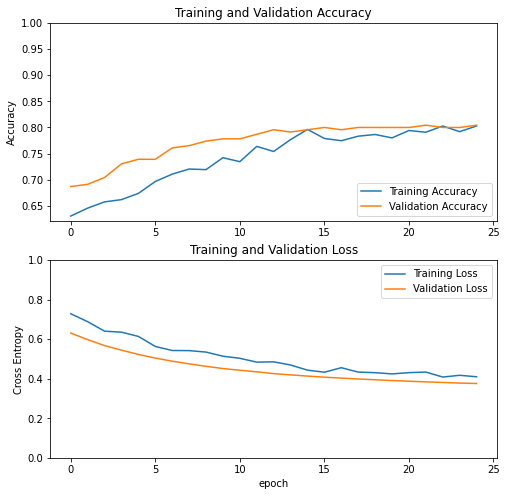

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Finetune model


In [18]:
base_model.trainable = True

In [19]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [22]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds)

Epoch 25/35
29/29 [==============================] - 26s 541ms/step - loss: 0.3884 - accuracy: 0.8082 - val_loss: 0.3654 - val_accuracy: 0.8130
Epoch 26/35
29/29 [==============================] - 20s 557ms/step - loss: 0.3387 - accuracy: 0.8332 - val_loss: 0.3312 - val_accuracy: 0.8696
Epoch 27/35
29/29 [==============================] - 19s 526ms/step - loss: 0.3386 - accuracy: 0.8407 - val_loss: 0.3062 - val_accuracy: 0.8522
Epoch 28/35
29/29 [==============================] - 18s 503ms/step - loss: 0.3217 - accuracy: 0.8451 - val_loss: 0.3163 - val_accuracy: 0.8609
Epoch 29/35
29/29 [==============================] - 18s 507ms/step - loss: 0.2878 - accuracy: 0.8657 - val_loss: 0.3046 - val_accuracy: 0.8652
Epoch 30/35
29/29 [==============================] - 18s 508ms/step - loss: 0.2752 - accuracy: 0.8776 - val_loss: 0.2940 - val_accuracy: 0.8739
Epoch 31/35
29/29 [==============================] - 18s 502ms/step - loss: 0.2585 - accuracy: 0.8884 - val_loss: 0.2837 - val_accuracy:

In [23]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

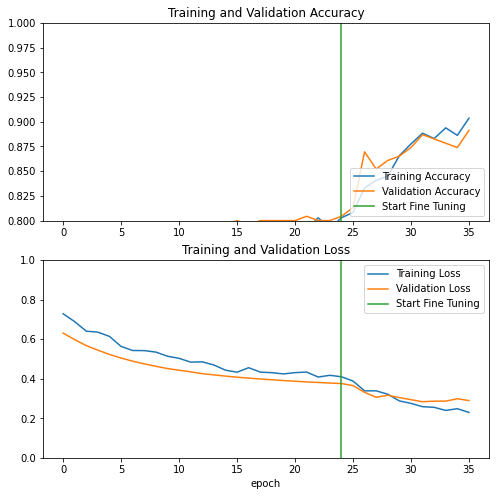

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Check results via test dataset

In [25]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  Path("/content/test/"),
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=10)

Found 20 files belonging to 2 classes.


In [26]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

2/2 [==============================] - 1s 22ms/step - loss: 0.1136 - accuracy: 0.9500
Test accuracy : 0.949999988079071


Predictions:
 [1 1 1 0 1 1 1 0 0 0]
Labels:
 [1 1 1 1 1 1 1 0 0 0]


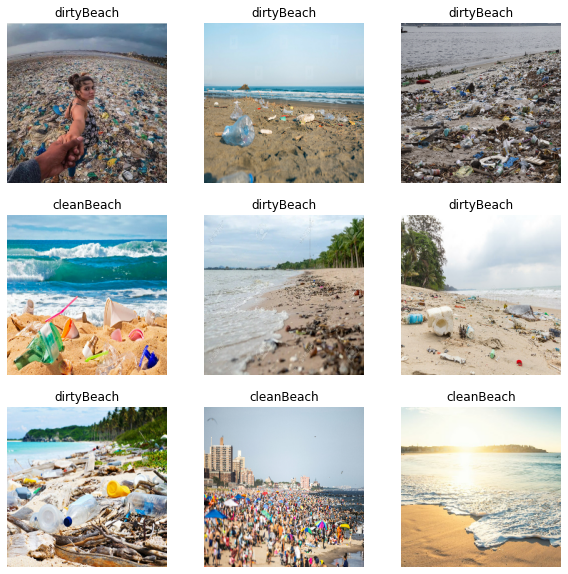

In [27]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(CLASSES[predictions[i]])
  plt.axis("off")

In [28]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets
